## Глубокое обучение в компьютерном зрении.


### Урок 7. Обработка видео.

**Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH.**

In [ ]:
%tensorflow_version 2.x

In [ ]:
import numpy as np

import random

import os

import glob

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

**Загрузим и разархивируем датасета KTH.**

In [ ]:
if 0:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

if 0:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

**Подготовим датасет для классификации.**

In [ ]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []

data_root = './'

for cls in classes:
    print(f'Processing class: {cls}')
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [ ]:
dataset[:5]

[('./walking/person19_walking_d4_uncomp.avi', 0),
 ('./walking/person03_walking_d2_uncomp.avi', 0),
 ('./walking/person08_walking_d1_uncomp.avi', 0),
 ('./walking/person07_walking_d1_uncomp.avi', 0),
 ('./walking/person17_walking_d3_uncomp.avi', 0)]

In [ ]:
TRAIN_LEN = 180

TEST_LEN = 30

random.shuffle(dataset)

train = dataset[:TRAIN_LEN]

test = dataset[TRAIN_LEN: (TRAIN_LEN + TEST_LEN)]

print('Train samples (subset):', len(train))
print('Test samples (subset):', len(test))

Train samples (subset): 180
Test samples (subset): 30


In [ ]:
train[:5]

[('./handwaving/person08_handwaving_d4_uncomp.avi', 4),
 ('./walking/person12_walking_d2_uncomp.avi', 0),
 ('./running/person25_running_d4_uncomp.avi', 2),
 ('./handclapping/person10_handclapping_d4_uncomp.avi', 5),
 ('./handwaving/person04_handwaving_d1_uncomp.avi', 4)]

In [ ]:
train_shapes = []

for i in range(len(train)):
    videodata = skvideo.io.vread(train[i][0])
    train_shapes.append(videodata.shape)

In [ ]:
train_shapes = sorted(train_shapes)
train_shapes[0], train_shapes[-1]

((230, 120, 160, 3), (1092, 120, 160, 3))

In [ ]:
test_shapes = []

for i in range(len(test)):
    videodata = skvideo.io.vread(test[i][0])
    test_shapes.append(videodata.shape)

In [ ]:
test_shapes = sorted(test_shapes)

test_shapes[0], test_shapes[-1]

((256, 120, 160, 3), (1492, 120, 160, 3))

**Визуализация кадра из видео.**

videodata shape: (478, 120, 160, 3)


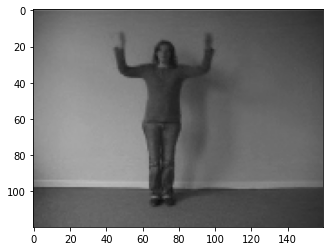

In [ ]:
videodata = skvideo.io.vread(train[0][0])

videodata = videodata.astype(np.float32) / 255.

print('videodata shape:', videodata.shape)

plt.imshow(videodata[50, ...])

**Визуализация движения.**

motion shape: (477, 120, 160, 1)


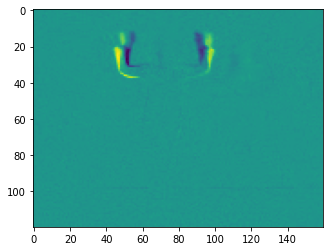

In [ ]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

print('motion shape:', motion.shape)

plt.imshow(motion[50, ..., 0])

**Создадим пайплайн данных.**

In [ ]:
path_to_train_video = []

train_labels = []

for tpl in train:
    path_to_train_video.append(tpl[0])
    train_labels.append(tpl[1])

In [ ]:
path_to_test_video = []

test_labels = []

for tpl in test:
    path_to_test_video.append(tpl[0])
    test_labels.append(tpl[1])

In [ ]:
def from_item_to_video(path_to_video):
    videodata = skvideo.io.vread(path_to_video.numpy().decode())
    videodata = videodata.astype(np.float32) / 255.
    return videodata

In [ ]:
def prepare(path_to_video, labels):
    videodata = tf.py_function(from_item_to_video, [path_to_video], [tf.float32])
    return videodata, labels

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((path_to_train_video, train_labels))

train_ds = train_ds.shuffle(buffer_size=len(path_to_train_video), reshuffle_each_iteration=True)

train_ds = train_ds.map(prepare, num_parallel_calls=1)

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((path_to_test_video, test_labels))

test_ds = test_ds.shuffle(buffer_size=len(path_to_train_video), reshuffle_each_iteration=True)

test_ds = test_ds.map(prepare, num_parallel_calls=1)

**Создадим собственный слой Conv + BatchNorm + ReLU.**

In [ ]:
class CBR(tf.keras.layers.Layer):
    
    def __init__(self, filters, kernel_size, strides, **kwargs):
        super().__init__()        
        self.conv = tf.keras.layers.Conv3D(filters, kernel_size, strides, **kwargs)
        self.bn = tf.keras.layers.BatchNormalization()
        
    def call(self, inp, training=False):
        out = self.conv(inp)
        out = self.bn(out, training)
        out = tf.nn.relu(out)        
        return out

**Создадим модель CNN.**

In [ ]:
WEIGHT_DECAY = 0.001

wd = tf.keras.regularizers.l2(WEIGHT_DECAY)

In [ ]:
def build_model():
    x = tf.keras.layers.Input(shape=(None, None, None, 3))
    
    out = CBR(32, (5, 5, 5), (1, 2, 2), padding='same', kernel_regularizer=wd)(x)
    out = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(out)

    out = CBR(64, (5, 5, 5), (1, 2, 2), padding='same', kernel_regularizer=wd)(out)
    out = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(out)

    out = CBR(64, (5, 5, 5), (1, 2, 2), padding='same', kernel_regularizer=wd)(out)
    out = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(out)

    out = tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None, kernel_regularizer=wd)(out)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.GlobalAveragePooling3D()(out)

    out = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=wd)(out)
    out = tf.keras.layers.Dropout(0.5)(out)
    out = tf.keras.layers.Dense(6, activation=None)(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

**Подготовка к обучению.**

In [ ]:
NUM_EPOCHS = 10

LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    )

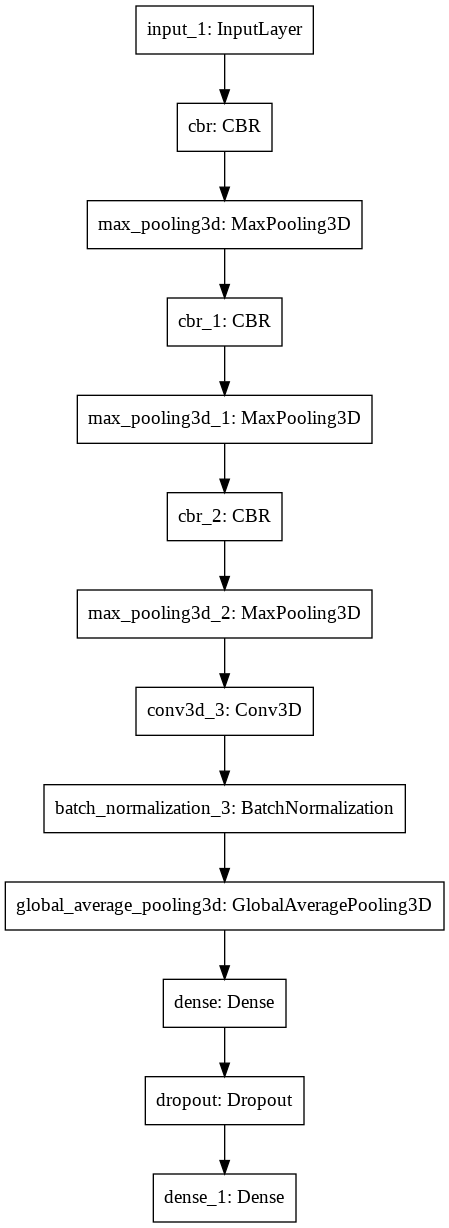

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/my_model', 
    write_graph=False, update_freq=100, profile_batch=0)

**Обучение модели.**

In [ ]:
%%time

NUM_EPOCHS = 10

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/10
180/180 [==============================] - 826s 5s/step - loss: 1.8287 - val_loss: 1.7981
Epoch 2/10
180/180 [==============================] - 161s 893ms/step - loss: 1.7974 - val_loss: 1.7921
Epoch 3/10
180/180 [==============================] - 160s 886ms/step - loss: 1.7924 - val_loss: 1.7890
Epoch 4/10
180/180 [==============================] - 158s 878ms/step - loss: 1.7920 - val_loss: 1.7904
Epoch 5/10
180/180 [==============================] - 157s 875ms/step - loss: 1.7906 - val_loss: 1.7890
Epoch 6/10
180/180 [==============================] - 157s 875ms/step - loss: 1.7890 - val_loss: 1.7881
Epoch 7/10
180/180 [==============================] - 157s 872ms/step - loss: 1.7852 - val_loss: 1.7875
Epoch 8/10
180/180 [==============================] - 157s 873ms/step - loss: 1.7882 - val_loss: 1.7875
Epoch 9/10
180/180 [==============================] - 157s 873ms/step - loss: 1.7905 - val_loss: 1.7872
Epoch 10/10
180/180 [==============================] - 157s 871ms/s

**Оценка качества модели.**

In [ ]:
%%time

model.evaluate(test_ds)

30/30 [==============================] - 10s 346ms/step - loss: 1.7864
CPU times: user 7.03 s, sys: 4.93 s, total: 12 s
Wall time: 11.4 s


1.7863972187042236

In [ ]:
prediction = model.predict(test_ds.take(1))

In [ ]:
prediction

array([[ 0.10805774, -0.09256724,  0.01828016, -0.08647811, -0.03522424,
         0.05997062]], dtype=float32)

In [ ]:
cls_pred = np.argmax(prediction)

print('True class:', test_labels[0])
print('Predicted class:', cls_pred)

True class: 2
Predicted class: 0
